### Матричные факторизации

В данной работе вам предстоит познакомиться с практической стороной матричных разложений.
Работа поделена на 4 задания:
1. Вам необходимо реализовать SVD разложения используя SGD на explicit данных
2. Вам необходимо реализовать матричное разложения используя ALS на implicit данных
3. Вам необходимо реализовать матричное разложения используя BPR на implicit данных
4. Вам необходимо реализовать матричное разложения используя WARP на implicit данных

Мягкий дедлайн 13 Октября (пишутся замечания, выставляется оценка, есть возможность исправить до жесткого дедлайна)

Жесткий дедлайн 20 Октября (Итоговая проверка)

In [1]:
import implicit
import pandas as pd
import numpy as np
import scipy.sparse as sp

from lightfm.datasets import fetch_movielens

В данной работе мы будем работать с explicit датасетом movieLens, в котором представленны пары user_id movie_id и rating выставленный пользователем фильму

Скачать датасет можно по ссылке https://grouplens.org/datasets/movielens/1m/

In [2]:
ratings = pd.read_csv('ml-1m/ratings.dat', delimiter='::', header=None, 
        names=['user_id', 'movie_id', 'rating', 'timestamp'], 
        usecols=['user_id', 'movie_id', 'rating'], engine='python')

In [3]:
movie_info = pd.read_csv('ml-1m/movies.dat', delimiter='::', header=None, 
        names=['movie_id', 'name', 'category'], engine='python', encoding="utf-8")

Explicit данные

In [4]:
ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
5,1,1197,3
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4


Для того, чтобы преобразовать текущий датасет в Implicit, давайте считать что позитивная оценка это оценка >=4

In [5]:
implicit_ratings = ratings.loc[(ratings['rating'] >= 4)]

In [6]:
implicit_ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
3,1,3408,4
4,1,2355,5
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4
10,1,595,5
11,1,938,4
12,1,2398,4


Удобнее работать с sparse матричками, давайте преобразуем DataFrame в CSR матрицы

In [7]:
users = implicit_ratings["user_id"]
movies = implicit_ratings["movie_id"]
user_item = sp.coo_matrix((np.ones_like(users), (users, movies)))
user_item_t_csr = user_item.T.tocsr()
user_item_csr = user_item.tocsr()

В качестве примера воспользуемся ALS разложением из библиотеки implicit

Зададим размерность латентного пространства равным 64, это же определяет размер user/item эмбедингов

In [8]:
model = implicit.als.AlternatingLeastSquares(factors=64, iterations=100, calculate_training_loss=True)

В качестве loss здесь всеми любимый RMSE

In [9]:
model.fit(user_item_t_csr)

100%|██████████| 100/100 [00:35<00:00,  2.84it/s, loss=0.0135]


Построим похожие фильмы по 1 movie_id = Истории игрушек

In [10]:
movie_info.head(5)

,movie_id,name,category
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
get_similars = lambda item_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() for x in model.similar_items(item_id)]

In [12]:
model.similar_items(1)

[(1, 0.99999994),
 (3114, 0.8021193),
 (2355, 0.60374033),
 (34, 0.45237458),
 (588, 0.41679263),
 (2384, 0.4007462),
 (1566, 0.38947463),
 (1907, 0.38830313),
 (364, 0.3763652),
 (2687, 0.36963454)]

Как мы видим, симилары действительно оказались симиларами.

Качество симиларов часто является хорошим способом проверить качество алгоритмов.

P.S. Если хочется поглубже разобраться в том как разные алгоритмы формируют разные латентные пространства, рекомендую загружать полученные вектора в tensorBoard и смотреть на сформированное пространство

In [13]:
get_similars(1, model)

['0    Toy Story (1995)',
 '3045    Toy Story 2 (1999)',
 "2286    Bug's Life, A (1998)",
 '33    Babe (1995)',
 '584    Aladdin (1992)',
 '2315    Babe: Pig in the City (1998)',
 '1526    Hercules (1997)',
 '1838    Mulan (1998)',
 '360    Lion King, The (1994)',
 '2618    Tarzan (1999)']

Давайте теперь построим рекомендации для юзеров

Как мы видим юзеру нравится фантастика, значит и в рекомендациях ожидаем увидеть фантастику

In [14]:
get_user_history = lambda user_id, implicit_ratings : [movie_info[movie_info["movie_id"] == x]["name"].to_string() for x in implicit_ratings[implicit_ratings["user_id"] == user_id]["movie_id"]]

In [15]:
get_user_history(4, implicit_ratings)

['3399    Hustler, The (1961)',
 '2882    Fistful of Dollars, A (1964)',
 '1196    Alien (1979)',
 '1023    Die Hard (1988)',
 '257    Star Wars: Episode IV - A New Hope (1977)',
 '1959    Saving Private Ryan (1998)',
 '476    Jurassic Park (1993)',
 '1180    Raiders of the Lost Ark (1981)',
 '1885    Rocky (1976)',
 '1081    E.T. the Extra-Terrestrial (1982)',
 '3349    Thelma & Louise (1991)',
 '3633    Mad Max (1979)',
 '2297    King Kong (1933)',
 '1366    Jaws (1975)',
 '1183    Good, The Bad and The Ugly, The (1966)',
 '2623    Run Lola Run (Lola rennt) (1998)',
 '2878    Goldfinger (1964)',
 '1220    Terminator, The (1984)']

Получилось! 

Мы действительно порекомендовали пользователю фантастику и боевики, более того встречаются продолжения тех фильмов, которые он высоко оценил

In [16]:
get_recommendations = lambda user_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() 
                                               for x in model.recommend(user_id, user_item_csr)]

In [17]:
get_recommendations(4, model)

['585    Terminator 2: Judgment Day (1991)',
 '1271    Indiana Jones and the Last Crusade (1989)',
 '1284    Butch Cassidy and the Sundance Kid (1969)',
 '2502    Matrix, The (1999)',
 '1178    Star Wars: Episode V - The Empire Strikes Back...',
 '1182    Aliens (1986)',
 '3402    Close Encounters of the Third Kind (1977)',
 '847    Godfather, The (1972)',
 '2460    Planet of the Apes (1968)',
 '1884    French Connection, The (1971)']

Теперь ваша очередь реализовать самые популярные алгоритмы матричных разложений

Что будет оцениваться:
1. Корректность алгоритма
2. Качество получившихся симиларов
3. Качество итоговых рекомендаций для юзера

In [18]:
from factorization import SVD, SVDS
from datetime import datetime

In [19]:
get_similars = lambda item_id, model : movie_info[movie_info["movie_id"].isin(model.similar_items(item_id))][["name", "category"]]

get_recommendations = lambda user_id, model : movie_info[movie_info["movie_id"].isin(model.recommend(user_id))][["name", "category"]]

get_user_history = lambda user_id, implicit_ratings : movie_info[movie_info["movie_id"].isin(implicit_ratings[implicit_ratings["user_id"] == user_id]["movie_id"])][["name", "category"]]

In [20]:
def test(model):
    item_id = 1
    target = movie_info[movie_info.movie_id == item_id]
    print(f"Similar to {target.name.item()} ({target.category.item()}):")
    sims = model.similar_items(item_id)
    
    for idx, i in enumerate(sims):
        selected = movie_info[movie_info.movie_id == i]
        print(f"{idx + 1}) {selected.name.item()} ({selected.category.item()})")
    
    print()
    
    user_id = 4
    print(f"Recommended movies for user {user_id}:")
    recs = model.recommend(user_id)
    
    for idx, i in enumerate(recs):
        selected = movie_info[movie_info.movie_id == i]
        print(f"{idx + 1}) {selected.name.item()} ({selected.category.item()})")

### Задание 1. Не использую готовые решения, реализовать SVD разложение используя SGD на explicit данных

In [21]:
user_item_exp = sp.coo_matrix((ratings["rating"], (ratings["user_id"], ratings["movie_id"])))

Iter:   10 | RMSE: 1.84004E+00
Iter:   20 | RMSE: 1.33858E+00
Iter:   30 | RMSE: 1.15557E+00
Iter:   40 | RMSE: 1.06731E+00
Iter:   50 | RMSE: 1.01779E+00
Iter:   60 | RMSE: 9.87205E-01
Iter:   70 | RMSE: 9.67011E-01
Iter:   80 | RMSE: 9.52994E-01
Iter:   90 | RMSE: 9.42873E-01
Iter:  100 | RMSE: 9.35325E-01
Iter:  110 | RMSE: 9.29536E-01
Iter:  120 | RMSE: 9.24987E-01
Iter:  130 | RMSE: 9.21330E-01
Iter:  140 | RMSE: 9.18326E-01
Iter:  150 | RMSE: 9.15809E-01
Iter:  160 | RMSE: 9.13654E-01
Iter:  170 | RMSE: 9.11770E-01
Iter:  180 | RMSE: 9.10089E-01
Iter:  190 | RMSE: 9.08554E-01
Iter:  200 | RMSE: 9.07120E-01
Iter:  210 | RMSE: 9.05750E-01
Iter:  220 | RMSE: 9.04410E-01
Iter:  230 | RMSE: 9.03071E-01
Iter:  240 | RMSE: 9.01706E-01
Iter:  250 | RMSE: 9.00288E-01
Iter:  260 | RMSE: 8.98794E-01
Iter:  270 | RMSE: 8.97201E-01
Iter:  280 | RMSE: 8.95489E-01
Iter:  290 | RMSE: 8.93641E-01
Iter:  300 | RMSE: 8.91647E-01
Iter:  310 | RMSE: 8.89499E-01
Iter:  320 | RMSE: 8.87198E-01
Iter:  3

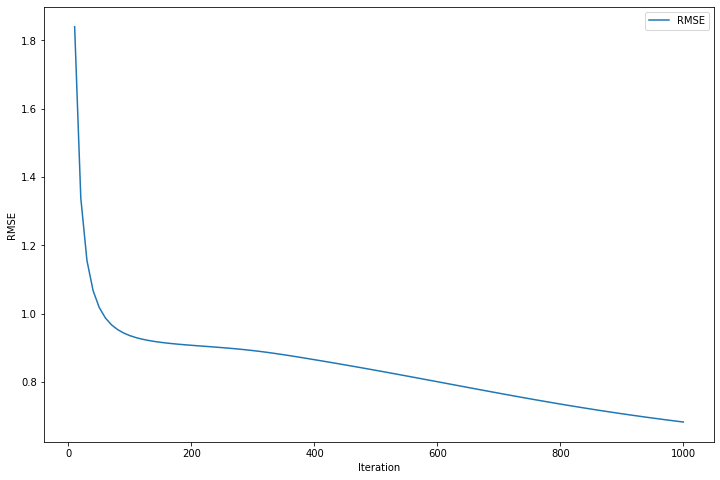

Similar to Toy Story (1995) (Animation|Children's|Comedy):
0) Toy Story (1995) (Animation|Children's|Comedy)
1) Toy Story 2 (1999) (Animation|Children's|Comedy)
2) Tarzan (1999) (Animation|Children's)
3) War at Home, The (1996) (Drama)
4) That Thing You Do! (1996) (Comedy)
5) Mulan (1998) (Animation|Children's)
6) Cats Don't Dance (1997) (Animation|Children's|Musical)
7) Anne Frank Remembered (1995) (Documentary)
8) Macao (1952) (Adventure)
9) Polish Wedding (1998) (Comedy)
Recommended movies for user 4:
0) Cool Hand Luke (1967) (Comedy|Drama)
1) Shawshank Redemption, The (1994) (Drama)
2) Bridge on the River Kwai, The (1957) (Drama|War)
3) Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963) (Sci-Fi|War)
4) Saving Private Ryan (1998) (Action|Drama|War)
5) Sanjuro (1962) (Action|Adventure)
6) To Kill a Mockingbird (1962) (Drama)
7) One Flew Over the Cuckoo's Nest (1975) (Drama)
8) Schindler's List (1993) (Drama|War)
9) Fargo (1996) (Crime|Drama|Thriller)
CPU time

In [22]:
%%time
model_svd = SVD(64, iterations=1000, lr=1e-4, verbose=True, weight_decay=1e-2)
model_svd.fit(user_item_exp)

timestamp = datetime.now()
model_svd.logger.save(f"log.{timestamp.date()}_{timestamp.time()}.csv")
model_svd.logger.plot("iter", "rmse", label="RMSE", x_label="Iteration", y_label="RMSE")

test(model_svd)

Iter:   10 | RMSE: 2.22436E+00
Iter:   20 | RMSE: 2.13856E+00
Iter:   30 | RMSE: 2.11669E+00
Iter:   40 | RMSE: 2.10652E+00
Iter:   50 | RMSE: 2.10915E+00


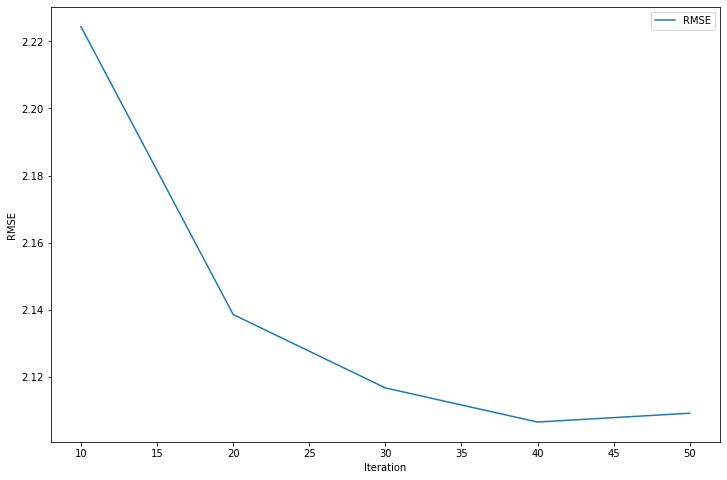

Similar to Toy Story (1995) (Animation|Children's|Comedy):
0) Toy Story (1995) (Animation|Children's|Comedy)
1) Toy Story 2 (1999) (Animation|Children's|Comedy)
2) Bug's Life, A (1998) (Animation|Children's|Comedy)
3) Brother's Kiss, A (1997) (Drama)
4) Aladdin (1992) (Animation|Children's|Comedy|Musical)
5) They Bite (1996) (Drama)
6) Lion King, The (1994) (Animation|Children's|Musical)
7) I'll Never Forget What's 'is Name (1967) (Comedy|Drama)
8) Happy Weekend (1996) (Comedy)
9) War Stories (1995) (Documentary)
Recommended movies for user 4:
0) Men With Guns (1997) (Action|Drama)
1) Midnight Run (1988) (Action|Adventure|Comedy|Crime)
2) Great Day in Harlem, A (1994) (Documentary)
3) Father of the Bride (1950) (Comedy)
4) Being There (1979) (Comedy)
5) Persuasion (1995) (Romance)
6) Lady Eve, The (1941) (Comedy|Romance)
7) French Connection, The (1971) (Action|Crime|Drama|Thriller)
8) Caddyshack (1980) (Comedy)
9) Animal House (1978) (Comedy)
CPU times: user 10min 20s, sys: 7.48 s, to

In [23]:
%%time
model_svds = SVDS(64, iterations=50, lr=1e-2, verbose=True, weight_decay=1e-2, save_every=10)

model_svds.fit(user_item_exp)

timestamp = datetime.now()
model_svds.logger.save(f"log.{timestamp.date()}_{timestamp.time()}.csv")
model_svds.logger.plot("iter", "rmse", label="RMSE", x_label="Iteration", y_label="RMSE")

test(model_svds)

### Задание 2. Не использую готовые решения, реализовать матричное разложение используя ALS на implicit данных

In [24]:
from factorization import ALS

Iter:    1 | RMSE: 9.63317E-03
Iter:    2 | RMSE: 6.79684E-04
Iter:    3 | RMSE: 1.29134E-04
Iter:    4 | RMSE: 5.73057E-05
Iter:    5 | RMSE: 4.00564E-05


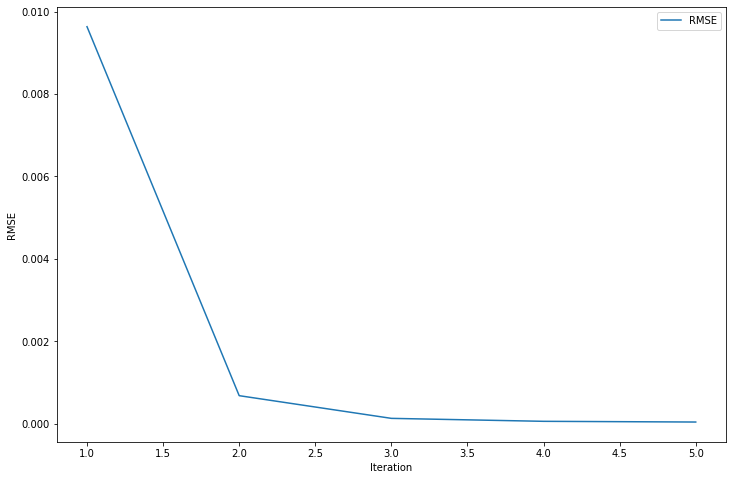

Similar to Toy Story (1995) (Animation|Children's|Comedy):
0) Toy Story (1995) (Animation|Children's|Comedy)
1) Mr. Nice Guy (1997) (Action|Comedy)
2) Mortal Kombat (1995) (Action|Adventure)
3) Rush Hour (1998) (Action|Thriller)
4) Mulan (1998) (Animation|Children's)
5) Bad Boys (1995) (Action)
6) Time Bandits (1981) (Adventure|Fantasy|Sci-Fi)
7) Rescuers Down Under, The (1990) (Animation|Children's)
8) Santa Clause, The (1994) (Children's|Comedy|Fantasy)
9) Batman Returns (1992) (Action|Adventure|Comedy|Crime)
Recommended movies for user 4:
0) Jails, Hospitals & Hip-Hop (2000) (Drama)
1) 1-900 (1994) (Romance)
2) Honigmond (1996) (Comedy)


ValueError: can only convert an array of size 1 to a Python scalar

In [25]:
model_als = ALS(64, 5, 1e-4, 1e-5, True)

model_als.fit(user_item_csr)

timestamp = datetime.now()
model_als.logger.save(f"log.{timestamp.date()}_{timestamp.time()}.csv")
model_als.logger.plot("iter", "rmse", label="RMSE", x_label="Iteration", y_label="RMSE")

test(model_als)

### Задание 3. Не использую готовые решения, реализовать матричное разложение BPR на implicit данных

In [ ]:
from factorization import BPR

### Задание 4. Не использую готовые решения, реализовать матричное разложение WARP на implicit данных

In [ ]:
# model_bpr = BPR(64, int(1e5), 1e-3, 1e-5, True)

# model_bpr.fit(user_item_csr, batch_size=64)

# timestamp = datetime.now()
# model_bpr.logger.save(f"log.{timestamp.date()}_{timestamp.time()}.csv")
# model_bpr.logger.plot("iter", "AUC", label="AUC", x_label="Iteration", y_label="AUC")

In [ ]:
# get_similars(1, model_bpr)

In [ ]:
# get_user_history(4, implicit_ratings)

In [ ]:
# get_recommendations(4, model_bpr)